In [129]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn.functional as F 
from torch import nn
import sys
sys.path.insert(1, '/Users/leonkiesgen/Documents/Python/BA_Optimization_ML/MaschineLearning/visualisation')
import json_ImExport
import LogDataImport
import random
import matplotlib.pyplot as plt
sys.path.insert(1,"/Users/leonkiesgen/Documents/Python/src/tqdm")

#import torch.utils.tensorboard import SummaryWriter


from tqdm.notebook import tqdm
import time
    
torch.manual_seed(0)

## Data Import

In [130]:
with tqdm(total=4) as pbar:
    #Json
    Jsondata=json_ImExport.loadData("/Users/leonkiesgen/Documents/Python/Kappa_variation_vmax100.json")
    #Log File (Monteblanco)
    pbar.update(1)
    Logdata_MB=LogDataImport.get_data("/Users/leonkiesgen/Documents/Python/mod_local_trajectory/logs/ltpl/2019_12_01/15_00_59_data.csv")

    #Log File (Berlin)
    pbar.update(1)
    ValLogdata_B=LogDataImport.get_data("/Users/leonkiesgen/Documents/Python/mod_local_trajectory/logs/ltpl/2019_12_05/12_19_36_data.csv")

    #Log File (Modena)
    pbar.update(1)
    ValLogdata_M=LogDataImport.get_data("/Users/leonkiesgen/Documents/Python/mod_local_trajectory/logs/ltpl/2019_12_05/15_41_27_data.csv")

    #Log File (zalazone)
    pbar.update(1)
    ValLogdata_Z=LogDataImport.get_data("/Users/leonkiesgen/Documents/Python/mod_local_trajectory/logs/ltpl/2019_12_05/15_51_25_data.csv")

    #print(ValLogdata_Z)

## Define NN Model

In [139]:
class RNN(nn.Module):
    def __init__(self,input_size,output_size,hidden_dim,n_layers):
        super(RNN, self).__init__()
        self.n_layers=n_layers
        self.hidden_dim=hidden_dim
        self.rnn= nn.RNN(input_size,hidden_dim,n_layers,nonlinearity="relu",batch_first=True,bidirectional=True)
        self.fc = nn.Linear(2*hidden_dim, output_size)
        
        self.calcH = nn.RNN(input_size,hidden_dim,n_layers,nonlinearity="relu",batch_first=True,bidirectional=True)
    def forward(self,x,hidden):
        vini=x[:,0,:].squeeze()
        hidden=self.initHidden(x[:,0,:])
        r_out,hidden =self.rnn(x[:,1:,:],hidden)
        output = self.fc(r_out)

        return output
    
    def initHidden(self,vini):
        
        hidden=self.calcH(vini.unsqueeze(0),None)
        return torch.zeros(self.n_layers*2,1,self.hidden_dim)
        
        

## Data Preperation

In [145]:

model=RNN(input_size=1,output_size=1,hidden_dim=10,n_layers=1)
#tb= SummaryWriter()
#tb.add_graph(model)

class Normalize():

    def __init__(self,data,scale=None):

        if scale is None:
            self.max=np.max(np.abs(data))
        else:
            self.max=scale
        print("Max is: ",self.max )

    def __call__(self,x):
        return x/self.max

    def normal(self,x):
        return x*self.max

# For Json
def prepareData(data):
    
    prepareddata=[]
    for item in data:

        #Input Data --------------------
        inpdata=[]
        inpdata.append(item["v_ini"])
        inpdata.append(item["v_max"])
        inpdata.append(item["Power"])   
        inpdata.extend(item["Kappa"])

        #Label Data -------------------
        label=item["V_op"]

        #Convert to Tensors -----------
        inpdata=torch.Tensor(inpdata)
        label=torch.Tensor(label)


        tupledata=(inpdata,label)
        prepareddata.append((inpdata,label))
    

    return prepareddata

# For Log File
def prepareLogData(indata):
    #lowestLen=200
    prepareddata=[]

    #Initialize Nomalizer
    #kappaNormalize=Normalize(allkappa)
    kappaNormalize=Normalize(None,scale=0.05)
    VelNormalize=Normalize(None,scale=70)
    data=[]
    for d in indata:
        data.extend(d)

    for item in data:
        inpdata=[]
        #lowestLen= len(item[1]) if len(item[1])< lowestLen else lowestLen

        #Input Data --------------------
        inpdata.append(VelNormalize(item[1][0]))
        kappatmp=np.array(item[0][:])
        kappatmp=kappaNormalize(kappatmp)
        inpdata.extend(kappatmp) #Kappa
        
        #Label Data -------------------
        label=np.array(item[1][:])

        #Convert to Tensors -----------
        inpdata=torch.Tensor(inpdata)
        label=torch.Tensor(VelNormalize(label))

        tupledata=(inpdata,label)
        
        #print(inpdata.shape,label.shape)
        
        prepareddata.append((inpdata,label))
        
    #print(lowestLen)
    return prepareddata

traindata=prepareLogData([Logdata_MB]) #[Logdata_MB,ValLogdata_M,ValLogdata_Z]
valdata=prepareLogData([ValLogdata_B[:250]])
#print(traindata[1])

random.shuffle(traindata)
random.shuffle(valdata)


inputT=torch.reshape(traindata[1][0],[-1,1]).unsqueeze(0)
print(inputT.shape)


#h0= torch.zeros((2,1,10))
r_out,h1= model(inputT,None)

print(r_out.squeeze())

Max is:  0.05
Max is:  70
Max is:  0.05
Max is:  70
torch.Size([1, 137, 1])


ValueError: not enough values to unpack (expected 2, got 1)

In [146]:
from IPython.core.debugger import set_trace

from torch import optim
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

num_epochs = 25
batchsize=len(traindata)
train_tracker, val_tracker, accuracy_tracker = [], [], []


for i in tqdm(range(num_epochs),desc="Total Progress: ",leave=False):
    
    cum_loss = 0
    random.shuffle(traindata)
        
    for batch,(inp, vel) in enumerate(tqdm(traindata,desc="Training Data",leave=False),1):

        
        inp=inp.reshape([1,-1,1])
        vel=vel.reshape([1,-1,1])
        output= model(inp,None)

        output=output.view(-1,1)
        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history


        outputVel=torch.reshape(vel,[-1,1])

        loss = criterion(output, outputVel)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cum_loss += loss.item()

    train_tracker.append(cum_loss/len(traindata))
    
    #Validation
    test_loss = 0
    num_correct = 0
    total = 0
    
    random.shuffle(valdata)
    with torch.no_grad():
        for batch, (inp, vel) in enumerate(tqdm(valdata,desc="Valiation Data", leave=False),1):

            optimizer.zero_grad()
            inp=inp.reshape([1,-1,1])
            output= model(inp,None)
            output=output.view(-1,1)

            outputVel=torch.reshape(vel,[-1,1])

            loss = criterion(output, outputVel)
            test_loss += loss

        val_tracker.append(test_loss/len(valdata))
    print(f"Epoch({i+1}/{num_epochs}) | Training loss: {cum_loss/len(traindata)} | " ,end="")
    print(f"Val loss: {test_loss/len(valdata)} | ")


Epoch(1/25) | Training loss: 0.00912944733845865 | Val loss: 0.03075425699353218 | 


Epoch(2/25) | Training loss: 0.005793780685076465 | Val loss: 0.023584477603435516 | 


Epoch(3/25) | Training loss: 0.005553296501953557 | Val loss: 0.017609668895602226 | 


Epoch(4/25) | Training loss: 0.005320435969224006 | Val loss: 0.012796756811439991 | 


Epoch(5/25) | Training loss: 0.0050367165782686605 | Val loss: 0.018091637641191483 | 


Epoch(6/25) | Training loss: 0.00508028387097822 | Val loss: 0.02385111339390278 | 


Epoch(7/25) | Training loss: 0.005007556083754919 | Val loss: 0.012881336733698845 | 


Epoch(8/25) | Training loss: 0.005074210928150288 | Val loss: 0.014727703295648098 | 


Epoch(9/25) | Training loss: 0.004953491409081836 | Val loss: 0.01530294120311737 | 


Epoch(10/25) | Training loss: 0.0056465962128545025 | Val loss: 0.01894412934780121 | 


Epoch(11/25) | Training loss: 0.005250595875455168 | Val loss: 0.017745139077305794 | 


Epoch(12/25) | Training loss: 0.005238126245410155 | Val loss: 0.016925664618611336 | 


Epoch(13/25) | Training loss: 0.0052025763075250475 | Val loss: 0.02081487327814102 | 


Epoch(14/25) | Training loss: 0.005177540952075802 | Val loss: 0.015076528303325176 | 


Epoch(15/25) | Training loss: 0.005253494314239204 | Val loss: 0.016361553221940994 | 


Epoch(16/25) | Training loss: 0.0051662599355998045 | Val loss: 0.014552541077136993 | 


Epoch(17/25) | Training loss: 0.0052186821591229116 | Val loss: 0.01650289259850979 | 


Epoch(18/25) | Training loss: 0.0052011542102360685 | Val loss: 0.016688304021954536 | 


Epoch(19/25) | Training loss: 0.00516579974804991 | Val loss: 0.01772426627576351 | 


Epoch(20/25) | Training loss: 0.005222329325623191 | Val loss: 0.018117204308509827 | 


Epoch(21/25) | Training loss: 0.005208523415654727 | Val loss: 0.017296329140663147 | 


Epoch(22/25) | Training loss: 0.00516276610311871 | Val loss: 0.01673666387796402 | 


Epoch(23/25) | Training loss: 0.005244079028631719 | Val loss: 0.017495987936854362 | 


Epoch(24/25) | Training loss: 0.005321714768803207 | Val loss: 0.01583036594092846 | 


Epoch(25/25) | Training loss: 0.005145249135384646 | Val loss: 0.015078296884894371 | 


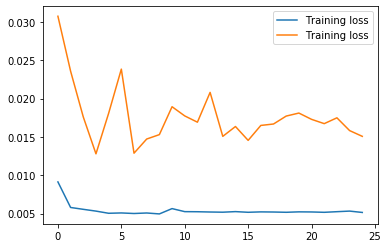

In [147]:
%matplotlib inline
plt.plot(train_tracker, label='Training loss')
plt.plot(val_tracker, label='Training loss')
plt.legend()

In [148]:
def predict(testexample,NN=model):
    VelNormalize= Normalize(None,70)

    criterion = nn.L1Loss()
    pData=testexample[0]
    pred=NN(pData[0])
    loss=criterion(pred,pData[1])

    %matplotlib inline
    pred=VelNormalize.normal(np.array(pred.tolist()))
    real=VelNormalize.normal(np.array(pData[1]))

    plt.plot(pred,label="Pred")
    plt.plot(real,label= "Real_Optimizer")
    print("Loss:", loss.item())

from sklearn.metrics import r2_score
def r2Score(example):
    
    PRED=[]
    REAL=[] 
    for (inp,label) in example:
        pred=model(inp)
        PRED.append(pred.tolist())
        REAL.append(label.tolist())


    SCORE=r2_score(PRED,REAL,multioutput='variance_weighted')
    return SCORE

In [149]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import time


def visual(x):
    #The Visualisation
    name="NN300200150_Iter250_MBZM"
    NR=x

    VelNormalize= Normalize(None,70)

    criterion = nn.L1Loss()
    testdata_inp,testdata_lable=[],[]

    testdata_inp=torch.clone(traindata[NR][0])
    #testdata_inp=torch.clone(valdata[NR][0])
    
    testdata_lable=torch.clone(traindata[NR][1])
    #testdata_lable=torch.clone(valdata[NR][1])
    
    
    
    #testdata[:]=
    #testdata[0]=0

    #print(testdata)
    inputRNN=torch.reshape(testdata_inp,[-1,1]).unsqueeze(0)

    print("Inp Shape: ", testdata_inp.shape)

    t1=time.time()
    pred = model(inputRNN,None)
    t2=time.time()

    pred=pred.squeeze()

    print("Out Shape: ", pred.shape)
    print("Evolived Time: " , (t2-t1)*1000,"ms")

    loss=criterion(pred,testdata_lable)

    %matplotlib inline
    pred=VelNormalize.normal(np.array(pred.tolist()))
    real=VelNormalize.normal(np.array(testdata_lable.tolist()))

    #Score=r2Score(valdata)
    scoreItem=r2_score(pred,testdata_lable)


    plt.plot(pred,label="Pred")
    plt.plot(real,label= "Real_Optimizer")

    plt.legend(["ML_Pred","Opt_Real"])
    plt.title("| "+name + " | Loss: "+str(np.round(loss.item(),4))+""+ " | " )
    plt.xlabel("Steps")
    plt.ylabel("Velocity")

    #scoreItem=r2_score(pred,valdata[NR][1])
    #text= str(np.round(scoreItem,4))+ "% [score] | "+str(np.round(loss.item(),5)) +" [loss] "
    MIN=min(pred)
    #plt.text(76,MIN,text,horizontalalignment='center',verticalalignment='center')
    #print("Loss:", loss.item())


    #print("The Score of the Train Dataset is: ",Score,"%")
    
interact(visual,x=(0,len(valdata)))

interactive(children=(IntSlider(value=125, description='x', max=250), Output()), _dom_classes=('widget-interac…

<function __main__.visual(x)>

## Save Model

In [ ]:
name="NN300200150_Iter250_MBZM"
save=True
PATH="/Users/leonkiesgen/Documents/Python/BA_Optimization_ML/MaschineLearning/mlModels/"+ name

In [ ]:
#Save MODEL
if save:
    torch.save(model.state_dict(), PATH+".pt")
    torch.save(model,PATH+".pth")

In [ ]:
#Load MODEL with same Structure
model=DNN()
model.load_state_dict(torch.load(PATH+".pt"))
model.eval()

In [ ]:
#Load MODEL with different Structure
model2=torch.load(PATH+".pth")
model2.eval()

In [ ]:
model2(traindata[37][0])